# Screening for side effects of Covid-19 drug candidates on cardiovascular development 

# Analysis notebook

In [1]:
%load_ext autoreload

In [38]:
%autoreload
import os
from glob import glob
import pandas as pd
import numpy as np

from glob import glob
from functions import analysis as ana
from functions.literature_search import searchPubmed
from functions.analysis import joined_find
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from importlib import reload
from functions.literature_search import find_intersection

import math
import datetime



# Pubmed search 

Add the list of drugs

In [4]:
drug_list = list(pd.read_excel("E:/Data_Drug_Screening_CovidBox/Master_Table/Druglist_LiteratureSearch.xlsx")["MODIFIED_NAME"])

In [ ]:
instance = searchPubmed("alexander.ernst@unibe.ch", drug_list, api_key="05b06f8adeace65e91dca5a0fac7d6ba330a")
df_literature = instance.multiple_context_search()[0]

In [ ]:
df_intersect = find_intersection(df_literature)

In [ ]:
# Uncomment if functions are not loaded
import sys
sys.path.append("Documents/GitHub/CoVasc_DrugScreen/functions/analysis.py")

# Get all the results from the Morphology assay
<b>Execute only if you have new data

Explanation:
    
One folder per experiment, the folders are identified by keywords which are referred to in the code to find the target content. 

Each folder has an "ExpID" at the end and contains 3 image folders, "Measurements"-folder and a "_PlateDescription.xlsx".

The images of one experiment are as tif files in 3 folders,     #1. 2x , #2. 4x and #3. 10x

Inside of the "Measurements"-folder are 4 tables "_HeartUnet_analysis","_ISVUnetAnalysis", "Summary_measurements", "Summary_heart" containing the analysis of the experiment.

The next cell loads all of them and accesses the "_10x" heartbeat movies to perform a frame rate correction on the heart beat counts. In this way alterations of the acquisition speed are corrected.

Afterwards the measurements are calibrated to "physical" units.

In [ ]:
# Uncomment to  save the table
#df_collection.to_excel("./tables/{}_Morphology_Assay_Collected_Measurements.xlsx".format(datetime.date.today()))

# Save the collected measurements of the morphology assay

In [30]:
df_collection = pd.read_excel("./tables/2022-07-28_Morphology_Assay_Collected_Measurements.xlsx")#.convert_dtypes()


In [31]:
df_collection.convert_dtypes().dtypes

Drug                      string
Well                      string
Number ISV (Count)         Int64
Edema                     string
Body length (µm)         Float64
Label                     string
Heart Beats (Count)        Int64
Frames (Count)             Int64
Avg_Frametime (ms)       Float64
Sum_Frametime (ms)       Float64
Ejection fraction (%)    Float64
image_name                string
ISV width (µm)           Float64
ISV length (µm)          Float64
Count_ISV                  Int64
Experiment ID              Int64
TRIVIAL_NAME              string
Concentration (µM)       Float64
Heart Rate (BPM)         Float64
ISV area (µm^2)          Float64
Repeat                     Int64
dtype: object

In [32]:
collist = ["Drug","Experiment ID","Concentration (µM)","Repeat","Body length (µm)","Heart Rate (BPM)","Ejection fraction (%)","Number ISV (Count)","ISV area (µm^2)"]
df_standardized = ana.standardize_globalMedian(df_collection, collist, "Control", ["Concentration (µM)"]).reset_index()
df_standardized = df_standardized[(df_standardized["Concentration (µM)"]==1.0) | (df_standardized["Drug"] == "Apilimod_1B03") | (df_standardized["Drug"] == "Niclosamide_1A02")]
df_standardized = df_standardized[~((df_standardized["Concentration (µM)"]==1.0) & (df_standardized["Drug"] == "Apilimod_1B03"))]
df_standardized

,Experiment ID,Drug,Concentration (µM),Body length (µm),Ejection fraction (%),Heart Rate (BPM),ISV area (µm^2),Number ISV (Count),Repeat
0,20,Papaverine_1C02,1.0,3913.125125,24.807550,148.170909,4056.362334,29.0,16.0
1,20,Papaverine_1C02,1.0,3716.451375,14.421981,148.568747,4579.268530,28.0,16.0
2,20,Papaverine_1C02,1.0,3715.203375,20.284032,146.856774,4078.519677,29.0,16.0
3,20,Papaverine_1C02,1.0,3755.711375,28.766251,149.653599,5026.003308,29.0,16.0
4,20,Papaverine_1C02,1.0,3707.266875,19.955845,NaN,5299.960847,28.0,16.0
...,...,...,...,...,...,...,...,...,...
2423,25,Control,1.0,3658.141338,11.201110,128.043225,3549.614032,29.0,16.0
2424,25,Control,1.0,3650.774888,18.834188,172.455983,5048.843792,29.0,16.0
2425,25,Control,1.0,3573.532463,NaN,151.185694,5230.734196,29.0,16.0
2426,25,Control,1.0,3678.427188,21.499525,160.202676,3065.415044,29.0,16.0


In [60]:
listdrugs = df_standardized.Drug.unique()

measurement = ['Body length (µm)',
       'Heart Rate (BPM)', 'Ejection fraction (%)', 'Number ISV (Count)',"ISV area (µm^2)"]

df_mannwhitney = ana.calculate_stats(df_standardized, "mannWhitney", listdrugs, measurement)
df_effsize = ana.calculate_stats(df_standardized, "effSize" ,listdrugs, measurement)
df_deltamed = ana.calculate_stats(df_standardized, "deltaMedian", listdrugs, measurement)

df_multiscore = df_mannwhitney.applymap(math.log10).abs() * df_effsize.abs() * df_deltamed

df_sign = ana.sign_stars(df_mannwhitney)
df_sign_T = df_sign.T

In [61]:
listdrugs = ["Control","Remdesivir_1A06","Hydroxychloroquine_1F11","Lopinavir_1H04","Ritonavir_1A11","Favipiravir_1D10","Ivermectin_1F05","Ribavirin_1F08","Umifenovir_2E02","Baricitinib_2C09","Molnupiravir",
             "Apilimod_1B03","Astemizole_1D04","Manidipine_1G03","Cabozantinib_2G04","Regorafenib_1B04","Sorafenib_1F09","Ponatinib_2A07","Pimozide_2G07","Tacrolimus_2B07"]
cdict  = {i: "white" if i != "Control" else "red" for i in listdrugs}
df_covid = df_standardized.set_index("Drug").loc[listdrugs].reset_index()
df_sign_covid_T = df_sign.loc[listdrugs].T

In [62]:
measurement = ['Body length (µm)',
       'Heart Rate (BPM)', 'Ejection fraction (%)', 'Number ISV (Count)',"ISV area (µm^2)"]

df_covid_plot = df_covid.reset_index().pivot_table(index=["Drug","Experiment ID","Concentration (µM)","Repeat","index"],values=measurement).stack().reset_index()
df_covid_plot.columns = ["Drug","Experiment ID","Concentration (µM)","Repeat","ID","Measurement","Value"]


In [63]:
repeats = {}

for i in df_covid_plot["Drug"].unique():
    
    ids = df_covid_plot.reset_index().set_index("Drug").loc[i]["Experiment ID"].unique()
    for rep,x in  enumerate(ids):
        df_covid_plot = df_covid_plot.reset_index().set_index(["Experiment ID","Drug"])
        df_covid_plot["Repeat"].loc[(x,i)] = rep
df_covid_plot = df_covid_plot.reset_index()    

C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\IPython\core\interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Fig. S4: Morphology assay boxplot with datapoints

<Figure size 1440x2880 with 0 Axes>

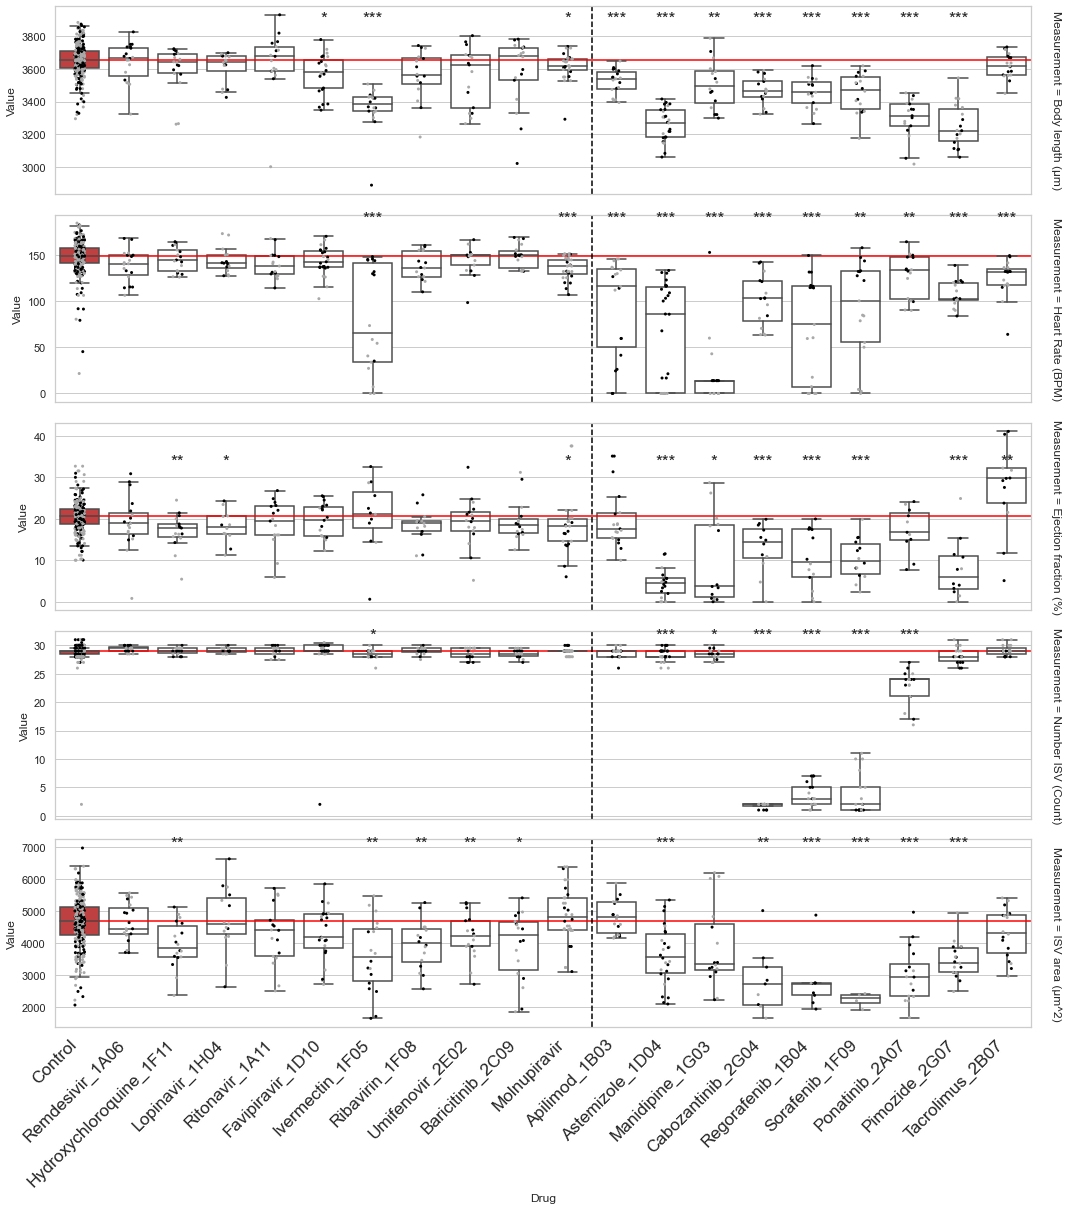

In [39]:
plt.figure(figsize=(20,40))
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(df_covid_plot,row="Measurement",sharey=False,row_order=measurement,height=3,aspect=5,margin_titles=True,legend_out=True,despine=False)
g.map_dataframe(sns.stripplot, x="Drug",y="Value", hue="Repeat",palette=["black","darkgrey"],size=3,order=listdrugs)
g.map_dataframe(sns.boxplot, x="Drug",hue="Drug",y="Value",palette=cdict,fliersize=0,dodge=False,order=listdrugs,saturation=0.5)

g.refline(x=10.5,color='0')
for ax,rowname in zip(g.axes.flat,g.row_names):
    y_control = df_covid_plot[(df_covid_plot["Drug"]=="Control") & (df_covid_plot["Measurement"]==rowname)]["Value"]
    ax.hlines(xmin=0, y = y_control.median(), xmax=19.5,color="red")
    
    [ax.text(x = num, y = y_control.max(), s = stars, size = 'x-large', ha='center') for num,stars in enumerate(df_sign_covid_T.loc[rowname]) if stars != "ns"]


plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
);

# Get all the results from the Behavior assay

In [168]:
dv_folder = "E:/Data_Drug_Screening_CovidBox/DanioVision"
directory = os.listdir(dv_folder)
df_program = pd.read_excel("E:/Data_Drug_Screening_CovidBox/DanioVision/20210115_A03_A11_ExpID0/150121_CoVasc_1min_bin_Bright_Dark_scheme.xlsx")
dict_program_melt = df_program.set_index("Bin").melt(var_name="Bin",value_name="Phase").set_index("Bin").to_dict()["Phase"]

for c, folders in enumerate(directory):
    #print(folders)
    if "_ExpID" in folders:
        
        expid = folders.split("_ExpID")[1]
        bin1_path = joined_find(dv_folder, folders, folder_measurements = "",keyword = "CoVasc_*1min*", file_type = ".xlsx",exclude=True)[0]
        filtered_path = list(filter(lambda x: "scheme" not in x ,bin1_path))
        map_path = joined_find(dv_folder, folders, folder_measurements = "",keyword = "_PlateMap", file_type = ".xlsx",exclude=True)[0]
        
        df_platemap = pd.read_excel(map_path)
        dict_platemap = df_platemap.dropna(axis=1).to_dict()
        df_bin1 = pd.read_excel(bin1_path, header = [0,1,2,3])
        
        df_bin1.columns = ['Trial', 'Well', 'Bin [1 sec]', 'Distance_moved [mm]', 'Velocity [mm/s]', 'Moving [s]','Not_Moving [s]']

        df_bin1["Phase"] = df_bin1["Bin [1 sec]"].apply(ana.assign_phase, dict_program_clean=dict_program_melt)
        df_bin1["Drug"] = df_bin1["Well"].apply(ana.assign_compounds, dict_compound=dict_platemap)
        
        check = list(filter(lambda x: "_c" in x ,list(df_bin1["Drug"])))
        
        if check:
            df_bin1["Concentration (µM)"] = df_bin1["Drug"].str.split("_c", expand=True)[1].astype(float)
            df_bin1["Concentration (µM)"].loc[np.isnan(df_bin1["Concentration (µM)"])] = 1.0
        else:
            df_bin1["Concentration (µM)"] = 1.
        
        df_bin1["Drug"] = df_bin1["Drug"].str.split("__c",expand=True)[0]    
        df_bin1["Experiment ID"] = expid
        df_bin1 = df_bin1.loc[df_bin1["Phase"] != "Remove"]
        df_bin1 = df_bin1.loc[df_bin1["Drug"] != "Blank"]
        
        
        df_bin1_plot = df_bin1.groupby(["Experiment ID","Drug","Concentration (µM)","Bin [1 sec]"]).mean()
        df_bin1_phasemedian = df_bin1.groupby(["Experiment ID","Drug","Concentration (µM)","Well","Phase"]).median()
        
        
        if c==0:
            df_collect_lineplot = df_bin1_plot.copy()
            df_collect_phasemedian = df_bin1_phasemedian.copy()
        else:
            df_collect_lineplot = pd.concat([df_collect_lineplot, df_bin1_plot],axis=0)
            df_collect_phasemedian = pd.concat([df_collect_phasemedian, df_bin1_phasemedian],axis=0)
        print(map_path)
        #if expid == "17":
        #    break
        

E:/Data_Drug_Screening_CovidBox/DanioVision/20210115_A03_A11_ExpID0\20210115_DanioVision_A03_A11_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20210125_B02_B11_ExpID01\20210125_DanioVision_B03_B11_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20210205_C02-C11_ExpID02\20210125_DanioVision_C03_C11_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20210205_D02-D11_ExpID04\20210125_DanioVision_D03_D11_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20210205_E02-E11_ExpID05\20210125_DanioVision_E02_E11_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20210303_F02-F11_ExpID06\20210302_DanioVision_F02_F11_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20210303_G02-G11_ExpID07\20210303_DanioVision_G02_G11_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20210304_2A02-2A11_ExpID09\20210303_DanioVision_2A02_2A11_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20210304_H02-H11_ExpID08\20210303_DanioVision_H02_H11_Pla

C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


E:/Data_Drug_Screening_CovidBox/DanioVision/20210423_Low_ExpID17\20210321_DanioVision_Low_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20210924_ScreenSelectedP1_ExpID19\20210910_DanioVision_ScreenSelectedP1_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20210924_ScreenSelectedP2_ExpID20\20210910_DanioVision_ScreenSelectedP2_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20220121_ScreenSelectedP3_ExpID21\20220121_DanioVision_ScreenSelectedP3_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20220121_ScreenSelectedP4_ExpID22\20220121_DanioVision_ScreenSelectedP4_PlateMap.xlsx
E:/Data_Drug_Screening_CovidBox/DanioVision/20220128_Molnupiravir_rep2_ExpID23\20220121_DanioVision_Molnupiravir_PlateMap.xlsx


# Filter out larvae that were not tracked properly

In [169]:
threshold_toofast = 6
df_pivot = df_collect_phasemedian.reset_index().pivot(index=["Experiment ID", "Drug", "Concentration (µM)", "Well"],values=["Distance_moved [mm]", "Velocity [mm/s]", "Moving [s]" ,"Not_Moving [s]"], columns="Phase")

df_collect_phasemedian = df_collect_phasemedian.drop(list(df_pivot[(df_pivot["Velocity [mm/s]"]["Accomodation"]>threshold_toofast)|(df_pivot["Velocity [mm/s]"]["Dark"]>threshold_toofast)].index))
df_collect_phasemedian = df_collect_phasemedian.reset_index()
df_collect_phasemedian = df_collect_phasemedian[df_collect_phasemedian["Drug"] != "Control-H2O"]


C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\IPython\core\interactiveshell.py:3169: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Batch correction with the median of the "experiment" control, corrected to the median of all controls

In [170]:
df_piv = df_collect_phasemedian.pivot(index=["Drug","Well","Experiment ID","Concentration (µM)"], columns="Phase", values=['Distance_moved [mm]', 'Velocity [mm/s]', 'Moving [s]',
       'Not_Moving [s]'])
    #df= df.reset_index()
df_piv.columns = df_piv.columns.map(('|'.join)).str.strip('|')
df_piv = df_piv.rename(columns={"Velocity [mm/s]|Bright":"Velocity [mm/s]|Light"})
df_dv = df_piv.reset_index()
df_dv["Replicate"] = df_dv["Experiment ID"]
df_dv["Velocity|Ratio Light/Dark"] =  -np.log((df_dv["Velocity [mm/s]|Light"]+0.001) / (df_dv["Velocity [mm/s]|Dark"]+0.001))

collist2 = list(df_dv.reset_index().columns)

df_standardized2 = ana.standardize_globalMedian(df_dv ,collist2, "Control", ["Concentration (µM)","Well","Replicate"]).reset_index()
df_standardized2 = df_standardized2[(df_standardized2["Concentration (µM)"]==1.0) | (df_standardized2["Drug"] == "Apilimod_1B03")| (df_standardized2["Drug"] == "Ivermectin_1F05")| (df_standardized2["Drug"] == "Niclosamide_1A02")]
df_standardized2 = df_standardized2[~((df_standardized2["Concentration (µM)"]==1.0) & (df_standardized2["Drug"] == "Apilimod_1B03"))]

In [171]:
df_standardized2["Velocity [mm/s]|Dark"].max()

5.7392675

# Assign repeated experiments

In [172]:

for i in df_standardized2["Drug"].unique():
 
    ids = df_standardized2.reset_index().set_index("Drug").loc[i]["Experiment ID"]
    
    
    if type(ids) == pd.Series:
        ids = ids.unique()

    for rep,x in  enumerate(ids):
        df_standardized2 = df_standardized2.reset_index().set_index(["Experiment ID","Drug"])
        df_standardized2["Replicate"].loc[(x,i)] = rep
df_standardized2 = df_standardized2.reset_index()    

C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\IPython\core\interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Calculate statistics and scores

In [173]:
alldrugs = df_standardized2.Drug.unique()

measurement2 = ["Moving [s]|Accomodation","Velocity [mm/s]|Light", "Velocity [mm/s]|Dark","Velocity|Ratio Light/Dark"]

df_mannwhitney2 = ana.calculate_stats(df_standardized2, "mannWhitney", alldrugs, measurement2)
df_effsize2 = ana.calculate_stats(df_standardized2, "effSize" ,alldrugs, measurement2)
df_deltamed2 = ana.calculate_stats(df_standardized2, "deltaMedian", alldrugs, measurement2)

df_multiscore2 = df_mannwhitney2.applymap(math.log10).abs() * df_effsize2.abs() * df_deltamed2

df_sign2 = ana.sign_stars(df_mannwhitney2)
df_sign_T2 = df_sign2.T

In [174]:
listdrugs = ["Control","Remdesivir_1A06","Hydroxychloroquine_1F11","Lopinavir_1H04","Ritonavir_1A11","Favipiravir_1D10","Ivermectin_1F05","Ribavirin_1F08","Umifenovir_2E02","Baricitinib_2C09","Molnupiravir",
             "Apilimod_1B03","Astemizole_1D04","Manidipine_1G03","Cabozantinib_2G04","Regorafenib_1B04","Sorafenib_1F09","Ponatinib_2A07","Pimozide_2G07","Tacrolimus_2B07"]
cdict2  = {i: "white" if i != "Control" else "red" for i in listdrugs}
df_covid2 = df_standardized2.set_index("Drug").loc[listdrugs].reset_index()
df_sign_T2 = df_sign2.loc[listdrugs].T


measurement2 = ["Moving [s]|Accomodation","Velocity [mm/s]|Light", "Velocity [mm/s]|Dark","Velocity|Ratio Light/Dark"]

df_covid_plot2 = df_covid2.pivot_table(index=["Drug","Replicate","index"],values=measurement2).stack().reset_index().drop("index",axis=1)
df_covid_plot2.columns = ["Drug","Repeat","Measurement","Value"]


# Fig. S5: Behavior assay boxplot wit data points 

<Figure size 1440x2880 with 0 Axes>

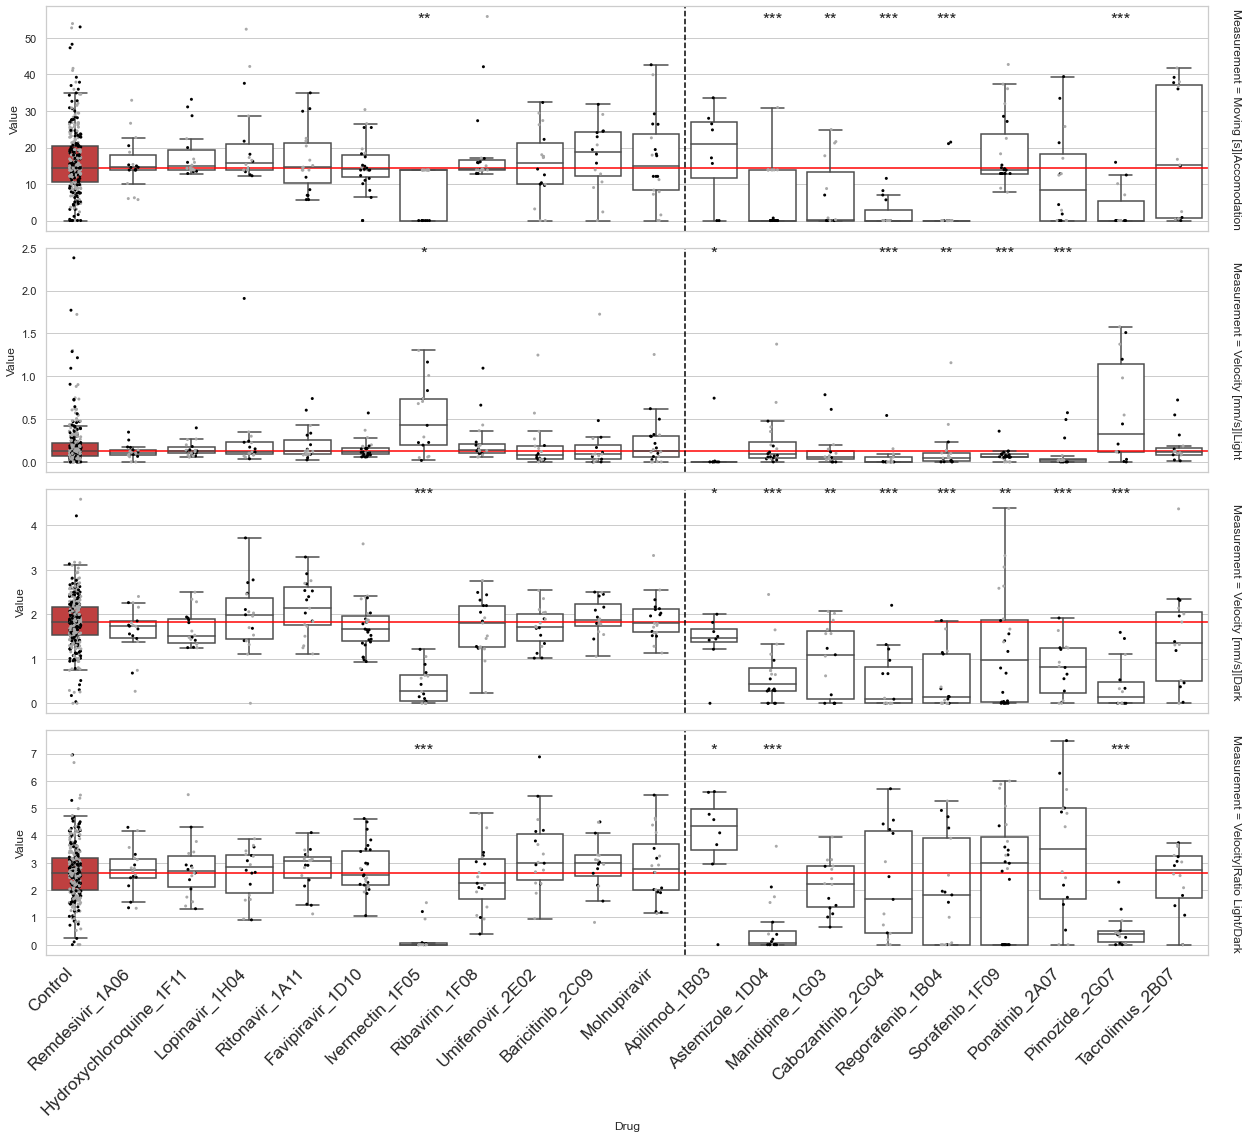

In [175]:
plt.figure(figsize=(20,40))
sns.set_context("paper")
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(df_covid_plot2,row="Measurement",sharey=False,row_order=measurement2,height=3.5,aspect=5,margin_titles=True,legend_out=True,despine=False)
g.map_dataframe(sns.stripplot, x="Drug",y="Value", hue="Repeat",palette=["black","darkgrey"],size=3,order=listdrugs)
g.map_dataframe(sns.boxplot, x="Drug",hue="Drug",y="Value",palette=cdict,fliersize=0,dodge=False,order=listdrugs,saturation=0.5)

g.refline(x=10.5,color='0')
for ax,rowname in zip(g.axes.flat,g.row_names):
    y_control2 = df_covid_plot2[(df_covid_plot2["Drug"]=="Control") & (df_covid_plot2["Measurement"]==rowname)]["Value"]
    ax.hlines(xmin=0, y = y_control2.median(), xmax=19.5,color="red")
    
    [ax.text(x = num, y = y_control2.max(), s = stars, size = 'x-large', ha='center') for num,stars in enumerate(df_sign_T2.loc[rowname]) if stars != "ns"]
    #if rowname == "Velocity|Ratio Dark-Bright":
    #    ax.set_yscale('log')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
);

# Fig. 2 Heatmap Overview

In [178]:
df_all_merge = pd.concat([df_multiscore,df_multiscore2],axis=1)
df_all_mannwhitney_merge = pd.concat([df_mannwhitney,df_mannwhitney2],axis=1)
annotation_all = ana.sign_stars(df_all_mannwhitney_merge)
annotation_binary_all = annotation_all == "ns"

In [188]:
df_all_merge_significant = df_all_merge[~annotation_binary_all].fillna(value=0)
df_g = ana.negpos_scale(df_all_merge_significant.copy())#negpos_scale(df_all_merge_significant.copy())

group_all0 = df_g[(df_g == 0).all(axis=1)]
group_all0["Group"] = "No effect"
df_group = pd.concat([pd.DataFrame(df_g[(df_g != 0).any(axis=1)].abs().idxmax(axis=1),columns=["Group"]),pd.DataFrame(group_all0["Group"])],axis=0, join='outer')

C:\Users\aernst\AppData\Local\Temp/ipykernel_16112/1369289129.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_all0["Group"] = "No effect"


In [183]:
df_g

,Body length (µm),Heart Rate (BPM),Ejection fraction (%),Number ISV (Count),ISV area (µm^2),Moving [s]|Accomodation,Velocity [mm/s]|Light,Velocity [mm/s]|Dark,Velocity|Ratio Light/Dark
GSK-369796_1C03,0.000000,-0.102928,0.146108,-0.04959,0.0,0.0,0.000000,0.000000,0.000000
Daclatasvir_1C04,0.000000,-0.199853,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
Lonafarnib_1C05,0.000000,-0.245995,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
Itraconazole_1C06,0.000000,-0.477220,0.000000,0.00000,0.0,0.0,-0.598845,0.000000,0.000000
GSK 983_1C07,0.000000,-0.085114,0.000000,0.00000,0.0,0.0,-0.195179,0.000000,0.255847
...,...,...,...,...,...,...,...,...,...
Ruxolitinib_1B11,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
Niclosamide_1A02,-0.148128,-0.189194,0.000000,0.00000,0.0,0.0,-1.517038,0.000000,0.964464
Apilimod_1B03,-0.278984,-2.104048,0.000000,0.00000,0.0,0.0,-1.060644,-0.292927,1.261181
Molnupiravir,-0.007477,-0.241445,-0.065034,0.00000,0.0,0.0,0.000000,0.000000,0.000000


In [189]:
df_cat = pd.concat([df_group,df_g],axis=1).sort_values("Group").reset_index().rename(columns={"index":"Drug"}).set_index(["Group","Drug"])
ordered_measurements = ['Body length (µm)',['Heart Rate (BPM)','Ejection fraction (%)'],['Number ISV (Count)','ISV area (µm^2)'],['Velocity [mm/s]|Dark','Velocity [mm/s]|Light','Moving [s]|Accomodation','Velocity|Ratio Light/Dark'],'No effect']

df_cat= df_cat.reset_index().set_index("Drug")

df_cat.index = [i.split("_")[0] for i in df_cat.index]
df_cat= df_cat.reset_index().rename(columns={"index":"Drug"}).set_index(["Group","Drug"])

Body length (µm) False
['Heart Rate (BPM)', 'Ejection fraction (%)'] True
['Number ISV (Count)', 'ISV area (µm^2)'] True
['Velocity [mm/s]|Dark', 'Velocity [mm/s]|Light', 'Moving [s]|Accomodation', 'Velocity|Ratio Light/Dark'] True


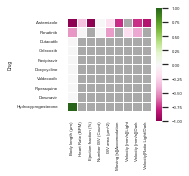

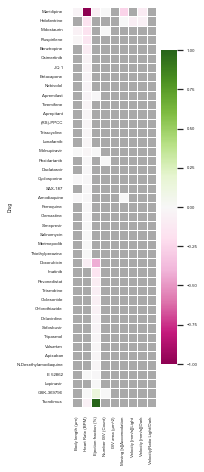

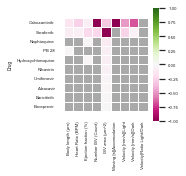

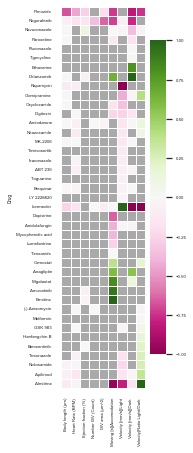

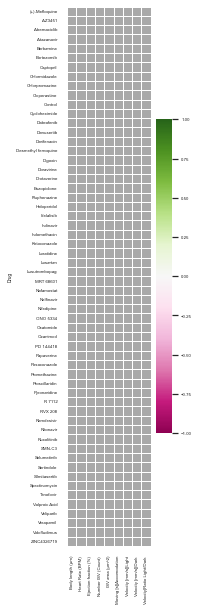

In [191]:
#plt.figure(figsize=(50,50))

#fig, axs = plt.subplots(2, 3, sharex=True, sharey=False,figsize=(50,50))

# creating a dictionary
font = {'size': 1}
scale= 4.8
plt.rc('font', **font)
# using rc function
sns.set(font_scale=0.4)

for i,m in enumerate(ordered_measurements):
    
    if m != "No effect":
        print(m, type(m) is list)
        if type(m) is list:
            df_pl = pd.DataFrame([])
            for ms in m:
                df_pre = df_cat.loc[ms].sort_values(ms)
                df_pl  = pd.concat([df_pl, df_pre],axis=0)
                
        else:
            df_pl = df_cat.loc[m].sort_values(m)
        plt.figure(figsize=(df_pl.shape[1]/scale,df_pl.shape[0]/scale))
        plt.rc('font', **font)
        sns.heatmap(df_pl,center=0,linewidths=0.5,cmap='PiYG',mask=(df_pl==0),fmt = '',square=True,vmin=-1,vmax=1).set_facecolor("darkgrey")
        
        #plt.savefig("E:/Data_Drug_Screening_CovidBox/Paper_Draft/20220706_Figures/Figure8_Heatmap_all/Heatmap_EffectGrouped_{}.pdf".format(i))
    
    else:
        plt.figure(figsize=(df_cat.loc[m].shape[1]/scale,df_cat.loc[m].shape[0]/scale))
        plt.rc('font', **font)
        
        sns.heatmap(df_cat.loc[m].sort_index(),center=0,linewidths=0.5,cmap='PiYG', mask=(df_cat.loc[m].sort_index()==0), fmt = '',square=True,vmin=-1,vmax=1).set_facecolor("darkgrey")
        #plt.savefig("E:/Data_Drug_Screening_CovidBox/Paper_Draft/20220706_Figures/Figure8_Heatmap_all/Heatmap_EffectGrouped_{}.pdf".format(i))
    

# Fig. 5 Heatmap Selected Drugs

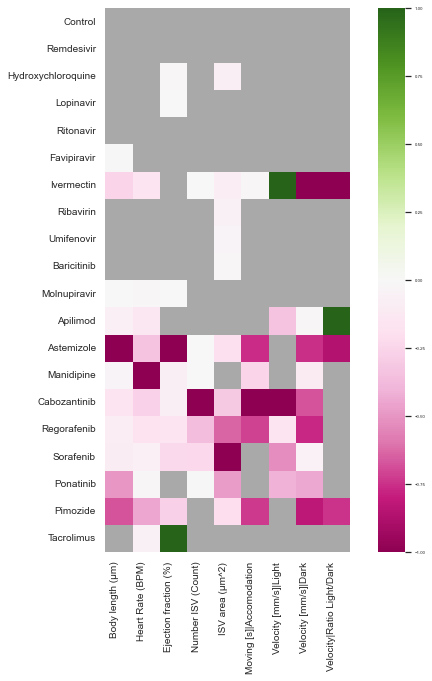

In [194]:
df_merge = pd.concat([df_multiscore,df_multiscore2],axis=1).loc[listdrugs]
df_merge.index = [i.split("_")[0] for i in df_merge.index]

df_mannwhitney_merge = pd.concat([df_mannwhitney,df_mannwhitney2],axis=1).loc[listdrugs]
df_mannwhitney_merge.index = [i.split("_")[0] for i in df_mannwhitney_merge.index]

annotation = ana.sign_stars(df_mannwhitney_merge)
annotation_binary = annotation == "ns"
annotation_binary.index = [i.split("_")[0] for i in annotation_binary.index]


plt.figure(figsize=(10,10))

#colormap.set_bad("black") 
sns.heatmap(ana.negpos_scale(df_merge),mask= annotation_binary,center=0,cmap='PiYG',fmt = '',square=True,vmin=-1,vmax=1).set_facecolor("darkgrey")
plt.xticks(
    rotation = 90, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 10  
);
plt.yticks(
    fontsize = 10  
);

#plt.savefig("E:/Data_Drug_Screening_CovidBox/Paper_Draft/Figures/Figure7_Heatmap/Selection_Heatmap.pdf")
plt.show()

In [196]:
df_covid_heart_development = pd.read_excel("E:/Data_Drug_Screening_CovidBox/Master_Table/CovidDrugScreen_Results_Literature_intersection.xlsx")

In [197]:
df_covid_heart_development.columns = [eval(x) if "(" in x else x for x in df_covid_heart_development.columns]

In [198]:
df_covid_heart_development

,SEARCH_NAME,TRIVIAL_NAME,Tag,Count_None,PID_None,Count_Dev,PID_Dev,Count_Heart,PID_Heart,Count_Covid,...,Over50_Count_Heart_Dev,Over50_Count_Heart_Covid,Over50_Count_Dev_Covid,Over100_Count_None,Over100_Count_Dev,Over100_Count_Heart,Over100_Count_Covid,Over100_Count_Heart_Dev,Over100_Count_Heart_Covid,Over100_Count_Dev_Covid
0,Niclosamide,Niclosamide,Niclosamide_1A02,1181,"['34517104', '34512959', '34483712', '34482191...",25,"['32842803', '32185932', '31790986', '31398420...",19,"['33772737', '33218969', '32876249', '32795515...",33,...,0,0,0,1,0,0,0,0,0,0
1,Lusutrombopag,Lusutrombopag,Lusutrombopag_1A03,59,"['34393785', '34386595', '34160821', '33917431...",0,[],0,[],0,...,0,0,0,0,0,0,0,0,0,0
2,Bemcentinib,Bemcentinib,Bemcentinib_1A04,109,"['34539853', '34429509', '34396051', '34376580...",3,"['31347670', '30189359', '27703030']",8,"['33151576', '32440898', '31080559', '30453385...",8,...,0,0,0,1,0,0,0,0,0,0
3,ONO 5334,ONO 5334,ONO 5334_1A05,27,"['32707573', '32511357', '30906325', '30663085...",0,[],0,[],2,...,0,0,0,0,0,0,0,0,0,0
4,Remdesivir,Remdesivir,Remdesivir_1A06,1991,"['34553728', '34551344', '34550900', '34550770...",49,"['34534511', '34531234', '34427297', '34426106...",145,"['34551344', '34511219', '34479903', '34464372...",1912,...,0,1,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Abacavir,Abacavir,Abacavir_2H07,2495,"['34524918', '34522425', '34518303', '34488812...",78,"['34175869', '33471090', '33211746', '32701581...",203,"['34488812', '34393518', '34157984', '33898535...",11,...,0,0,0,1,0,1,0,0,0,0
156,Chlorothiazide,Chlorothiazide,Chlorothiazide_2H08,2563,"['33942711', '33431709', '33406536', '32893505...",138,"['32555118', '20301356', '17177070', '11205055...",338,"['33942711', '32893505', '32639593', '32010863...",0,...,0,0,0,1,1,1,0,0,0,0
157,Apixaban,Apixaban,Apixaban_2H09,4455,"['34551881', '34548336', '34541920', '34541895...",38,"['34434677', '34126147', '33691765', '33520558...",756,"['34530470', '34513377', '34469922', '34445237...",46,...,0,0,0,1,0,1,0,0,0,0
158,Naphthoquine,Naphtoquine,Naphtoquine_2H10,57,"['33511926', '33269856', '32839220', '32687174...",1,['28790788'],1,['27075024'],0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_collect.to_csv("E:/Data_Drug_Screening_CovidBox/Master_Table/CovidDrugScreen_Results_MeanActivity_Daniovision.csv")

In [ ]:
pd.read_csv("E:/Data_Drug_Screening_CovidBox/Master_Table/CovidDrugScreen_Results_MeanActivity_Daniovision.csv").set_index(["Experiment ID","Drug"])

In [ ]:
plt.figure(figsize=(30,10))
sns.lineplot(data = df_bin1_plot, x="Bin [1 sec]", y="Velocity [mm/s]", hue="Drug")

plt.xticks(
    rotation = 90, 
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 10  
);

plt.yticks(
    fontsize = 10  
);


In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
fig = px.line(df_collect.loc["0"].reset_index(), x="Bin [1 sec]", y="Velocity [mm/s]", color='Drug')
fig.show()
